In [82]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [83]:
df = pd.read_csv("SBER.csv", parse_dates=["Date"], nrows = 311)

In [84]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.76%
1,2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%
2,2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%
3,2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%
4,2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%


In [85]:
df["Vol."] = df["Vol."].apply(lambda x : float(x[:-1]))
df["Change %"] = df["Change %"].apply(lambda x : float(x[:-1]))
df.sort_values(by="Date", inplace=True)
df.set_index("Date", inplace=True)
df = df.asfreq('D', method="ffill")
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.0,255.99,258.19,253.7,35.85,0.10
2020-01-04,255.0,255.99,258.19,253.7,35.85,0.10
2020-01-05,255.0,255.99,258.19,253.7,35.85,0.10
2020-01-06,253.9,254.75,254.84,251.4,22.35,-0.43
2020-01-07,253.9,254.75,254.84,251.4,22.35,-0.43


In [86]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,234.325044,234.240198,236.987841,231.154317,71.899626,0.025220
std,31.924844,31.883906,31.899241,31.935379,38.173981,2.299301
min,174.270000,175.000000,182.200000,172.150000,8.760000,-9.570000
25%,207.305000,207.092500,209.240000,204.400000,46.845000,-1.040000
50%,228.565000,229.000000,231.525000,226.260000,65.585000,0.065000
75%,265.442500,264.000000,267.297500,261.140000,87.010000,1.177500
max,293.300000,294.860000,296.070000,291.500000,263.040000,12.900000


In [87]:
train = df[df.index < "2021-01-01"]
test = df[df.index >= "2021-01-01"]

## Create test and training sets


In [88]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train)
stock_train = scaler.transform(train)
stock_test = scaler.transform(test)

In [89]:
stock_train

array([[0.73752969, 0.7362058 , 0.72001137, 0.75768838, 0.09504083,
        0.43035158],
       [0.73752969, 0.7362058 , 0.72001137, 0.75768838, 0.09504083,
        0.43035158],
       [0.73752969, 0.7362058 , 0.72001137, 0.75768838, 0.09504083,
        0.43035158],
       ...,
       [0.89283757, 0.91728025, 0.89283684, 0.92083991, 0.1076678 ,
        0.38228749],
       [0.88964005, 0.88619216, 0.87208641, 0.91024807, 0.0778331 ,
        0.42011571],
       [0.88964005, 0.88619216, 0.87208641, 0.91024807, 0.0778331 ,
        0.42011571]])

In [90]:
train_window = 2
import numpy as np
def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(price)
    print('Length = ', L)
    
    for i in range(L-tw):
        data_seq = price[i:i+tw]
        data_label = price[i+tw:i+tw+1][0][0]
        inout_seq.append((data_seq ,data_label))
    return inout_seq
    
train_seqs = create_in_out_sequences(stock_train, train_window)
test_seqs = create_in_out_sequences(stock_test, train_window)

Length =  364
Length =  90


In [91]:
train_seqs[0]

(array([[0.73752969, 0.7362058 , 0.72001137, 0.75768838, 0.09504083,
         0.43035158],
        [0.73752969, 0.7362058 , 0.72001137, 0.75768838, 0.09504083,
         0.43035158]]),
 np.float64(0.7375296912114011))

In [92]:
class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                       torch.zeros(1,1,self.hidden_layer_size),
                      )
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [93]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [94]:
from tqdm.notebook import tqdm
model.train()
        
epochs = 50
for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in tqdm(train_seqs):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)
        
        labels = labels.view(1)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i:3} loss: {average_loss:.10f}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   0 loss: 0.0132766629


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   1 loss: 0.0068491472


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   2 loss: 0.0082104790


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   3 loss: 0.0103872405


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   4 loss: 0.0114641258


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   5 loss: 0.0095972730


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   6 loss: 0.0077891365


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   7 loss: 0.0065515002


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   8 loss: 0.0057606523


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:   9 loss: 0.0052481586


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  10 loss: 0.0048606374


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  11 loss: 0.0045603150


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  12 loss: 0.0043304244


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  13 loss: 0.0041275075


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  14 loss: 0.0039569920


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  15 loss: 0.0038092928


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  16 loss: 0.0036800746


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  17 loss: 0.0035615762


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  18 loss: 0.0034559958


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  19 loss: 0.0033571102


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  20 loss: 0.0032576398


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  21 loss: 0.0031629605


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  22 loss: 0.0030763471


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  23 loss: 0.0029952237


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  24 loss: 0.0029197173


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  25 loss: 0.0028463169


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  26 loss: 0.0027760083


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  27 loss: 0.0027065732


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  28 loss: 0.0026340684


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  29 loss: 0.0025604321


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  30 loss: 0.0024909337


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  31 loss: 0.0024266628


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  32 loss: 0.0023686969


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  33 loss: 0.0023172998


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  34 loss: 0.0022684163


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  35 loss: 0.0022258569


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  36 loss: 0.0021858435


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  37 loss: 0.0021492063


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  38 loss: 0.0021136835


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  39 loss: 0.0020815029


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  40 loss: 0.0020511401


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  41 loss: 0.0020223349


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  42 loss: 0.0019945454


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  43 loss: 0.0019676614


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  44 loss: 0.0019417484


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  45 loss: 0.0019165580


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  46 loss: 0.0018921136


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  47 loss: 0.0018685264


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  48 loss: 0.0018458768


  0%|          | 0/362 [00:00<?, ?it/s]

epoch:  49 loss: 0.0018242606


In [95]:
model.eval()
actual = []
pred = []

for seq, labels in train_seqs:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

In [96]:
pred = torch.from_numpy(np.array(pred)).type(torch.Tensor)
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [97]:
print(pred)
print(actual)

tensor([0.8183, 0.8183, 0.7938, 0.7902, 0.8421, 0.8347, 0.8189, 0.8177, 0.8177,
        0.8475, 0.8284, 0.8189, 0.8332, 0.8662, 0.8710, 0.8710, 0.8733, 0.8776,
        0.8749, 0.8535, 0.8627, 0.8654, 0.8654, 0.8052, 0.8334, 0.8468, 0.8152,
        0.7978, 0.7957, 0.7957, 0.8189, 0.8321, 0.8272, 0.8031, 0.8182, 0.8234,
        0.8234, 0.7989, 0.8478, 0.8271, 0.8072, 0.7882, 0.7855, 0.7855, 0.7851,
        0.7712, 0.7764, 0.7855, 0.7816, 0.7811, 0.7811, 0.7811, 0.7415, 0.8123,
        0.7352, 0.6610, 0.6533, 0.6533, 0.6328, 0.7540, 0.6953, 0.6700, 0.5187,
        0.4972, 0.4972, 0.4972, 0.2766, 0.0737, 0.2020, 0.2750, 0.3302, 0.3302,
        0.1357, 0.1283, 0.1128, 0.2014, 0.2482, 0.3481, 0.3481, 0.1823, 0.2398,
        0.2395, 0.1662, 0.1659, 0.1476, 0.1476, 0.1964, 0.2213, 0.2042, 0.2437,
        0.2011, 0.2214, 0.2214, 0.2878, 0.3843, 0.3583, 0.4175, 0.3724, 0.3804,
        0.3804, 0.3482, 0.3549, 0.2353, 0.2578, 0.2821, 0.3137, 0.3137, 0.2679,
        0.2402, 0.2684, 0.2838, 0.2702, 

In [99]:
import numpy as np
pred_new = scaler.inverse_transform(np.c_[np.array(pred), np.zeros(362),np.zeros(362),np.zeros(362),np.zeros(362), np.zeros(362)])
print(pred_new[:,0])

[263.83820911 263.83820911 261.15855164 260.76802515 266.4506008
 265.63684792 263.90698854 263.77374879 263.77374879 267.03494539
 264.95124581 263.90659708 265.46921192 269.08043854 269.61038331
 269.61038331 269.86434264 270.32741309 270.03552134 267.69368686
 268.70244528 268.99840168 268.99840168 262.41151552 265.49024635
 266.95896964 263.50388316 261.59986999 261.36855659 261.36855659
 263.90482246 265.35153268 264.81835837 262.17539369 263.83509048
 264.39588227 264.39588227 261.71729478 267.06756702 264.80146037
 262.62943448 260.55017143 260.25070494 260.25070494 260.20268591
 258.68835107 259.25320098 260.25232297 259.82723062 259.76922285
 259.76922285 259.76922285 255.43832411 263.18266457 254.74679791
 246.62694343 245.77893132 245.77893132 243.54054    256.80276912
 250.37534397 247.61021784 231.04674581 228.69003587 228.69003587
 228.69003587 204.54188338 182.34142442 196.376892   204.37044697
 210.41802596 210.41802596 189.12167525 188.30854543 186.61371515
 196.311917

/var/folders/2c/1_dy62d12c725697ykpvzlkw0000gq/T/ipykernel_18519/2401850978.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pred_new = scaler.inverse_transform(np.c_[np.array(pred), np.zeros(362),np.zeros(362),np.zeros(362),np.zeros(362), np.zeros(362)])


In [100]:
actual_new = scaler.inverse_transform(np.c_[np.array(actual), np.zeros(362),np.zeros(362),np.zeros(362),np.zeros(362), np.zeros(362)])
print(actual_new[:,0])

[255.00000042 253.89999932 253.89999932 259.14999922 257.99000043
 258.18999707 258.18999707 258.18999707 262.40000009 259.0500009
 256.30999995 257.50999936 262.49999841 262.49999841 262.49999841
 266.28000277 268.06000158 266.5399971  263.73000319 265.48999842
 265.48999842 265.48999842 255.31999896 257.70000074 259.93999704
 257.31000272 252.20000178 252.20000178 252.20000178 253.99000238
 255.40000022 255.19999706 252.10999872 254.29999913 254.29999913
 254.29999913 252.25999947 254.50000229 254.50000229 253.88999753
 251.74999955 251.74999955 251.74999955 251.36000153 249.19999997
 249.6999981  250.15000033 250.7999992  250.7999992  250.7999992
 250.7999992  245.19000013 250.7999992  242.87999782 233.35999723
 233.35999723 233.35999723 228.17000154 236.63000168 235.26999973
 232.33000213 219.98999932 219.98999932 219.98999932 219.98999932
 201.20000046 194.52999929 175.90999996 198.60000009 198.60000009
 198.60000009 195.85000061 184.01       174.27       189.50999977
 195.6899997

/var/folders/2c/1_dy62d12c725697ykpvzlkw0000gq/T/ipykernel_18519/1935999407.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  actual_new = scaler.inverse_transform(np.c_[np.array(actual), np.zeros(362),np.zeros(362),np.zeros(362),np.zeros(362), np.zeros(362)])


## Evaluate the model


In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_new, pred_new)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(actual_new, pred_new))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2.155023546868595
Root Mean Squared Error (RMSE): 5.787473853189369


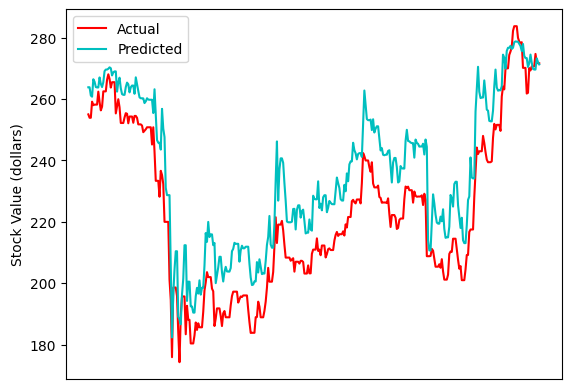

In [102]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,0], 'r-', label='Actual')
ax.plot(pred_new[:,0], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

# ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')

plt.show()